In [4]:
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from matplotlib import pyplot as plt

Plot images with their ground-truth labels, and predicted labels

In [2]:
i = 0
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]

In [5]:
test_df = pd.read_json(config['data_folder'] + '/test_df.json.bz2', compression='bz2')

test = hf.get_flow(df=test_df,
                   nr_classes=config['nr_classes'],
                   image_dimension=config['image_dimension'])


Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 49514 validated image filenames belonging to 20 classes.



Number of layers in basemodel: 339
Number of trainable layers: 0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
flatten (Flatten)            (None, 5632)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               721024    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 8,492,173
Trainable params: 723,604
Non-trainable params: 7,768,569
_________________________________________________________________
Predicting on test set:

1548/1548 - 767s
Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 49514 validated image filenames belonging to 20 classes.
Predicting on validation set:

1548/1548 - 92s


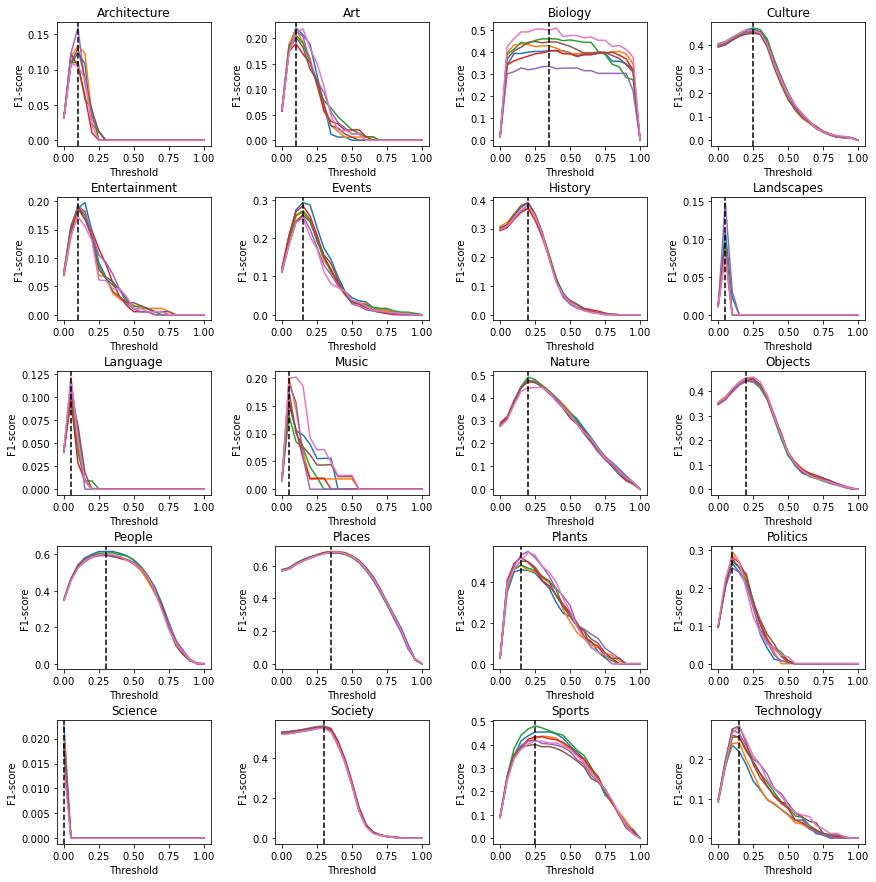

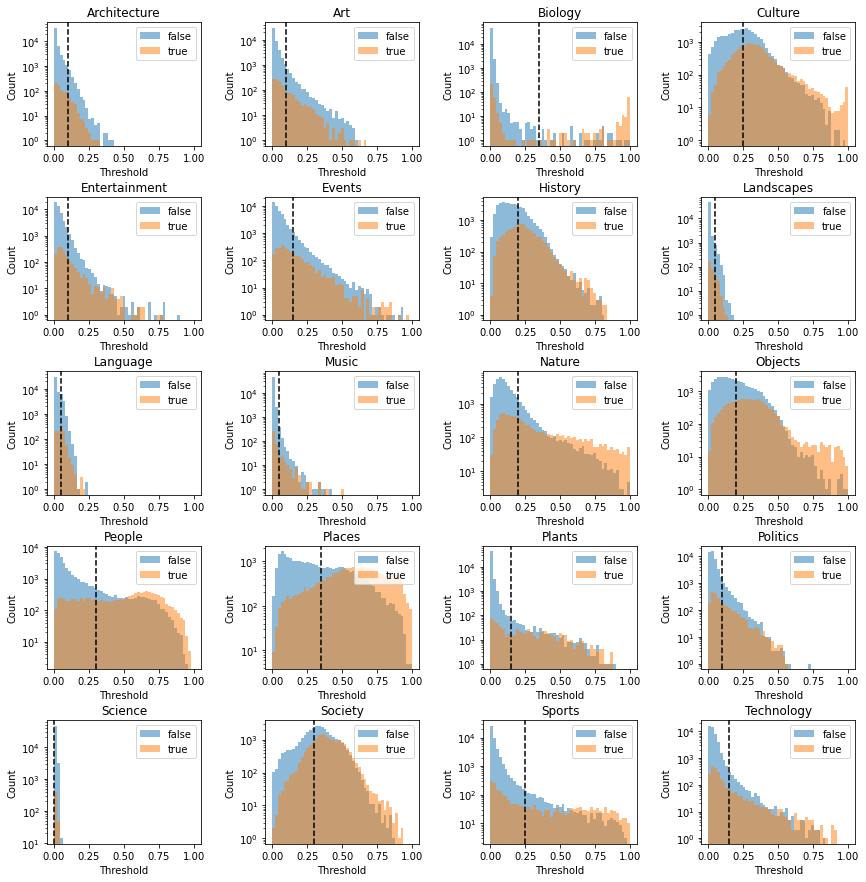

In [6]:
# Create model
model = hf.create_model(n_labels=config['nr_classes'], image_dimension=config['image_dimension'], model_name=config['basemodel'], number_trainable_layers=config['number_trainable_layers'])
latest = tf.train.latest_checkpoint(config['results_folder'] + '/checkpoints')
model.load_weights(latest)
# Predict on test set
print('Predicting on test set:\n')
probs_test = model.predict(test, verbose=2)
y_true_test = hf.get_y_true(shape=(test.samples, len(test.class_indices)), 
                            classes=test.classes)
# Get optimal thresholds
val_threshold = hf.get_flow(df_file=config['data_folder'] + '/val_threshold_df.json.bz2',
                            nr_classes=config['nr_classes'],
                            image_dimension=config['image_dimension'])
# Predict on validation set
print('Predicting on validation set:\n')
probs_val = model.predict(val_threshold, verbose=1)
y_true_val = hf.get_y_true(shape=probs_val.shape, classes=val_threshold.classes)
optim_thresholds = hf.get_optimal_threshold(y_true=y_true_val, 
                                            probs=probs_val, 
                                            thresholds=np.linspace(start=0, stop=1, num=21), 
                                            labels=list(val_threshold.class_indices.keys()), 
                                            N=7,
                                            image_path=config['results_folder'])
y_pred_test_per_class_threshold = 1 * (probs_test > optim_thresholds)

In [32]:
label_names = np.array(list(test.class_indices.keys()))

In [50]:
y_pred_test_per_class_threshold[5, :]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0])

In [60]:
letters=np.array(['a','b','c'])
mask=np.array([False,False,True])
letters[mask]

array(['c'], dtype='<U1')

In [68]:
mask_int = y_pred_test_per_class_threshold[5, :]
mask_bool=[x==1 for x in mask_int]
pred_labels = label_names[mask_bool]

In [70]:
''.join([label + ', ' for label in pred_labels])

'History, Objects, Places, Science, Society, '

<ipython-input-80-98984565a87e>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(random_indices.flatten()) / columns + 1, columns, i + 1)


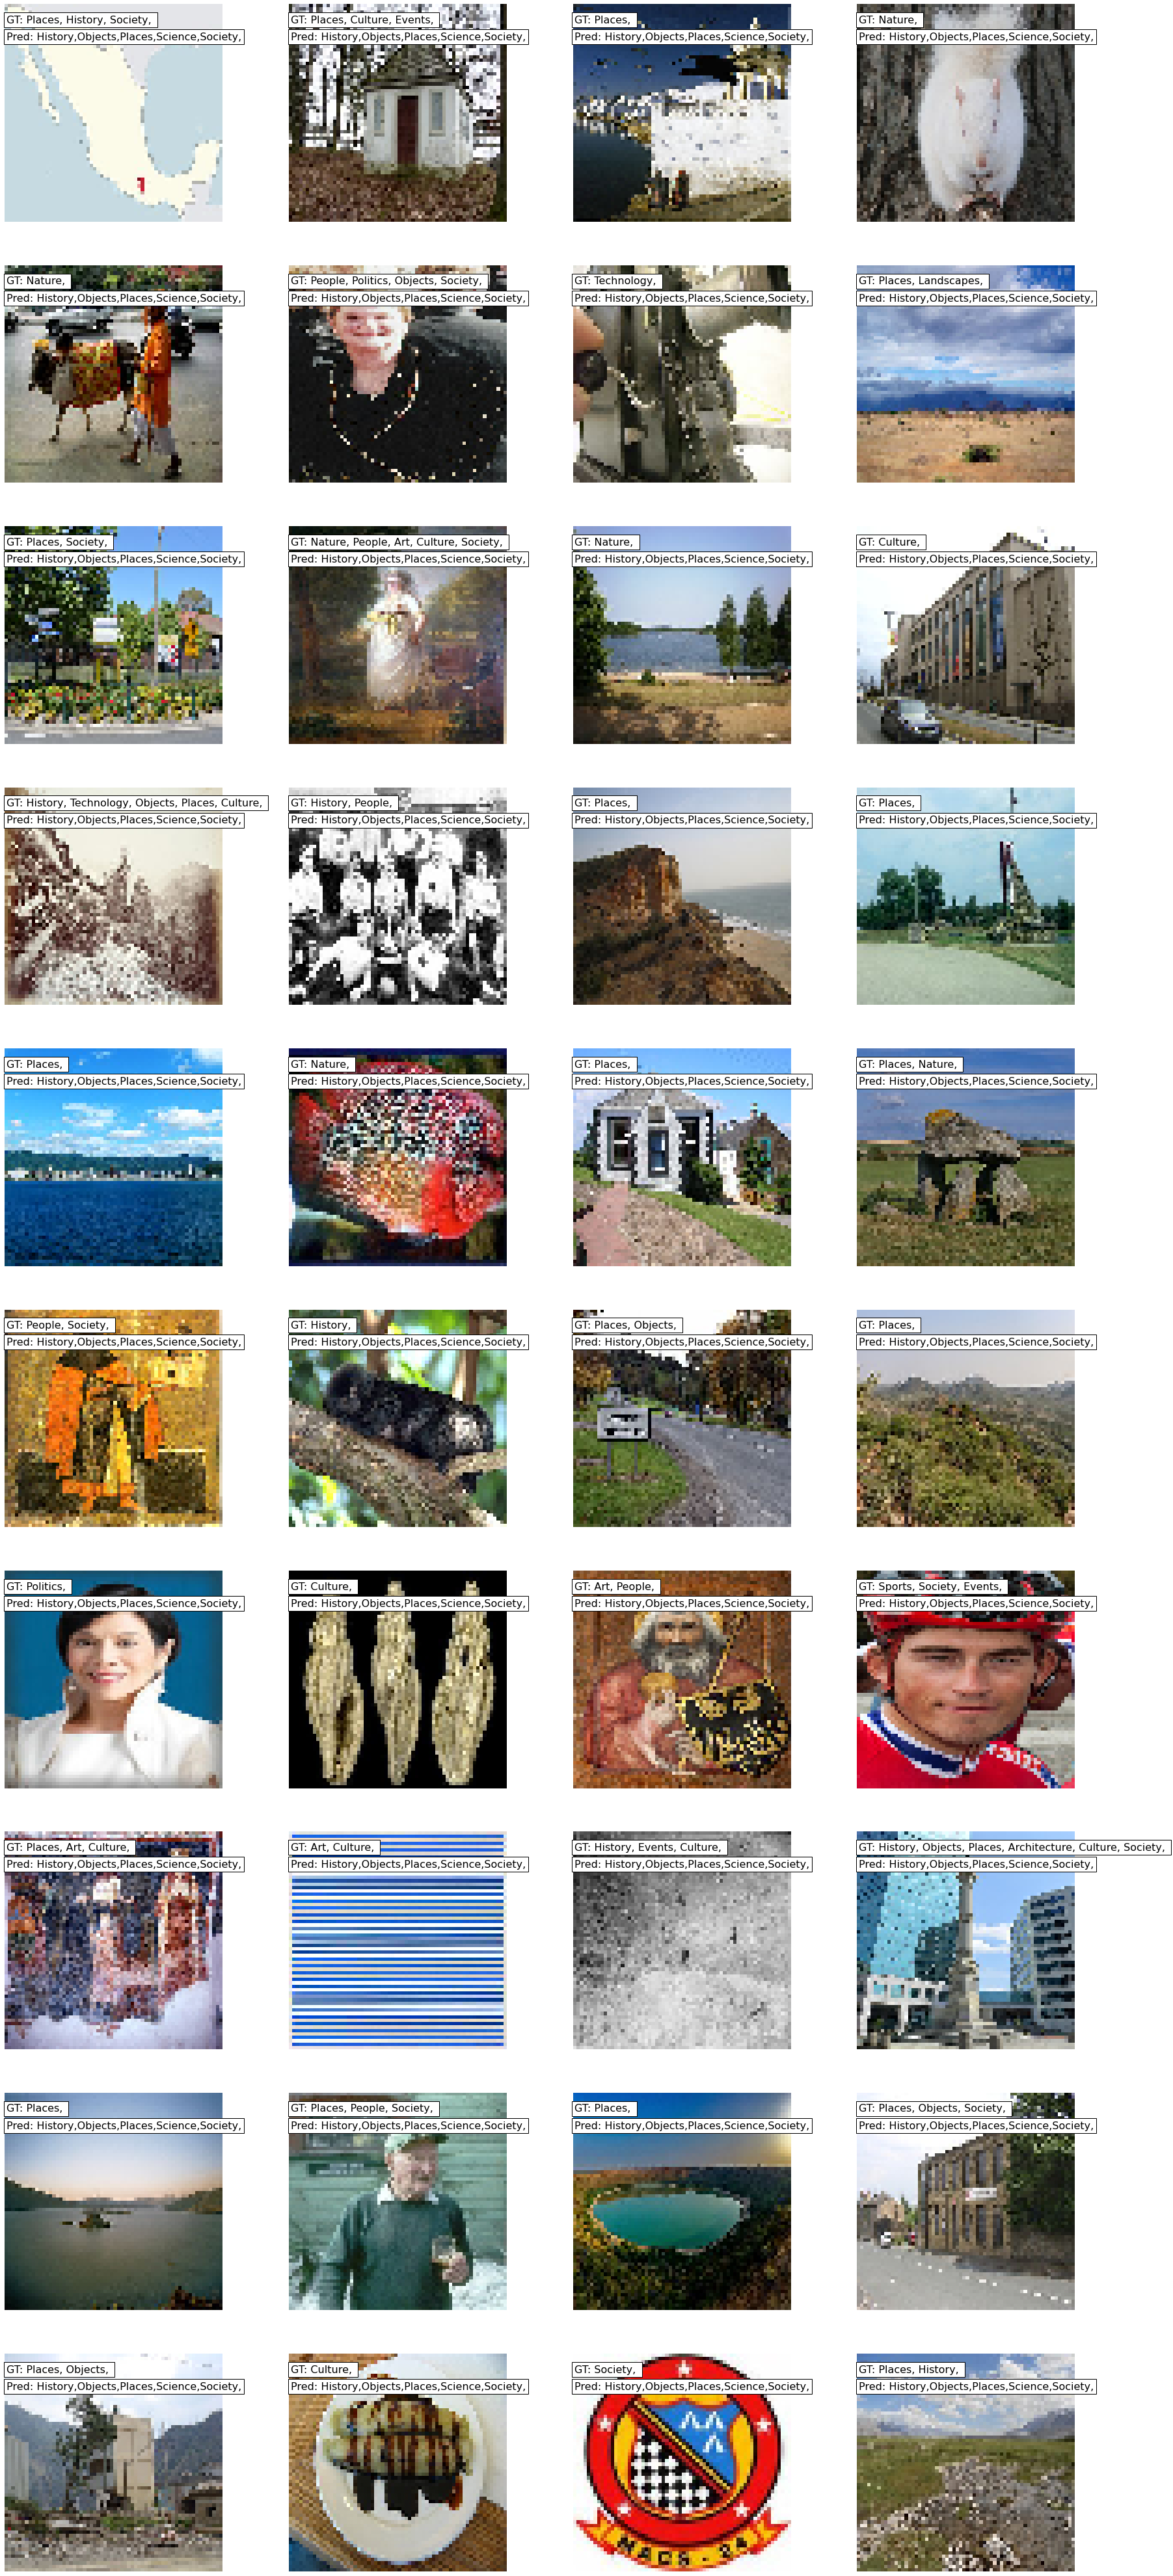

In [80]:
from tensorflow.keras.preprocessing.image import load_img

plt.figure(figsize=(30, 80))
columns = 4
rows = 10
random_indices = np.random.randint(low=0, high=test.samples, size=(rows, columns))

for i, idx in enumerate(random_indices.flatten()):
    path = '/scratch/WIT_Dataset/images/' + test_df.iloc[idx, :].url
    img = load_img(path, target_size=(64, 64))
    plt.subplot(len(random_indices.flatten()) / columns + 1, columns, i + 1)
    plt.imshow(img)
    plt.axis('off')
    gt_str = 'GT: '
    gt_str += ''.join([label + ', ' for label in test_df.iloc[idx, :].labels])
    plt.text(x=0, y=5, s=gt_str, fontsize=16, bbox=dict(facecolor='white', edgecolor='black'))

    mask = [x == 1 for x in y_pred_test_per_class_threshold[idx, :]]
    predicted_labels = label_names[mask]
    predicted_labels_str = 'Pred: '
    predicted_labels_str += ''.join([label + ',' for label in pred_labels])
    plt.text(x=0, y=10, s=predicted_labels_str, fontsize=16, bbox=dict(facecolor='white', edgecolor='black'))
    
